# Online Gradient Descent Based Portfolio Optimizer
Our portfolio optimizer relies on an online gradient descent based algorithm that looks to maximize our fitness function which combines soratino ratio, maximum drawdown, and expected returns. We trade with the Magnificient 7 stocks and train them over the dates of 2022-01-01 to 2023-12-31, using data provided by YFinance.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

In [ ]:
# Define the Magnificent 7 tickers
tickers = [
    # Technology & AI
    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "AVGO", "ORCL", "IBM", "CSCO",

    # Financials & Banking
    "JPM", "V", "MA", "GS", "MS", "BAC", "C", "AXP", "SCHW",

    # Healthcare & Pharma
    "UNH", "JNJ", "LLY", "PFE", "MRNA", "BMY", "GILD", "CVS", "VRTX", "ISRG",

    # Consumer Goods & Retail
    "WMT", "NKE", "PG", "TGT", "COST", "KO", "PEP", "MCD", "SBUX", "YUM",

    # Energy & Utilities
    "XOM", "CVX", "NEE", "DUK", "SO", "D", "ENB", "SLB", "EOG", "PSX",

    # Industrials & Defense
    "DE", "LMT", "RTX", "BA", "CAT", "GE", "HON", "UPS", "EMR", "NOC",

    # Real Estate & Infrastructure
    "PLD", "AMT", "EQIX", "O", "SPG", "VICI", "DLR", "WY", "EQR", "PSA",

    # Transportation & Automotive
    "TSLA", "FDX", "UPS", "GM", "F", "RIVN", "NIO", "CSX", "UNP", "DAL",

    # Semiconductors
    "TSM", "ASML", "AMD", "TXN", "INTC", "MU", "QCOM", "LRCX", "NXPI", "ADI",

    # Agriculture & Food
    "ADM", "BG", "CF", "TSN", "MOS", "FMC", "CAG", "SYY", "HRL", "MDLZ",

    # Entertainment & Media
    "NFLX", "DIS", "PARA", "WBD", "CMCSA", "SPOT", "LYV", "TTWO", "EA",

    # Meme Stocks
    "GME", "AMC"
]

# Fetch historical price data for 2022-2023 (training period)
train_start_date = "2022-01-01"
train_end_date = "2023-12-31"

# Fetch historical price data for 2024 (testing period)
test_start_date = "2024-01-01"
test_end_date = datetime.now().strftime("%Y-%m-%d")  # Today's date

print(f"Training period: {train_start_date} to {train_end_date}")
print(f"Testing period: {test_start_date} to {test_end_date}")

# Download adjusted close prices for both periods
train_prices = yf.download(tickers, start=train_start_date, end=train_end_date)["Close"]
test_prices = yf.download(tickers, start=test_start_date, end=test_end_date)["Close"]

print(f"Training data shape: {train_prices.shape}")
print(f"Testing data shape: {test_prices.shape}")

# Check for missing values
print(f"Missing values in training data: {train_prices.isna().sum().sum()}")
print(f"Missing values in testing data: {test_prices.isna().sum().sum()}")

# Fill any missing values with forward fill, then backward fill
train_prices = train_prices.fillna(method='ffill').fillna(method='bfill')
test_prices = test_prices.fillna(method='ffill').fillna(method='bfill')

[                       0%                       ]

Training period: 2022-01-01 to 2023-12-31
Testing period: 2024-01-01 to 2025-02-28


[*********************100%***********************]  109 of 109 completed
[*********************100%***********************]  109 of 109 completed
<ipython-input-63-a3c5de3ddfc9>:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_prices = train_prices.fillna(method='ffill').fillna(method='bfill')
<ipython-input-63-a3c5de3ddfc9>:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_prices = test_prices.fillna(method='ffill').fillna(method='bfill')


Training data shape: (501, 109)
Testing data shape: (290, 109)
Missing values in training data: 0
Missing values in testing data: 0


In [ ]:
# Import the OnlinePortfolioOptimizer class from the previous code
class OnlinePortfolioOptimizer:
    def __init__(self,
                 n_assets,
                 initial_learning_rate=0.01,
                 decay_rate=0.995,
                 momentum=0.9,
                 window_size=252,
                 alphas=(1.0, 1.0, 1.0, 0.5),
                 max_transaction_cost=0.02):

        self.n_assets = n_assets
        self.initial_lr = initial_learning_rate
        self.current_lr = initial_learning_rate
        self.decay_rate = decay_rate
        self.momentum = momentum
        self.window_size = window_size
        self.alphas = alphas
        self.max_transaction_cost = max_transaction_cost

        # Initialize weights equally
        self.weights = np.ones(n_assets) / n_assets
        self.velocity = np.zeros(n_assets)
        self.t = 0

    def _decay_learning_rate(self):
        self.current_lr = self.initial_lr * (self.decay_rate ** self.t)

    def _calculate_expected_returns_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()
        expected_returns = returns.mean()
        grad = expected_returns / 0.5
        return grad.values

    def _calculate_sortino_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()
        portfolio_returns = np.dot(returns, self.weights)

        rf_daily = 0.02 / 252
        excess_returns = returns - rf_daily

        negative_returns = excess_returns[portfolio_returns < 0]

        if len(negative_returns) > 0:
            downside_std = np.sqrt(np.mean(np.square(negative_returns)))
        else:
            downside_std = 1e-6

        grad = (excess_returns.mean() / (3.0 * downside_std))
        return grad.values

    def _calculate_drawdown_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()

        # Calculate cumulative returns for the portfolio
        portfolio_returns = np.dot(returns, self.weights)
        cumulative_returns = (1 + portfolio_returns).cumprod()

        # Find the maximum drawdown point
        peak = np.maximum.accumulate(cumulative_returns)
        drawdown = cumulative_returns / peak - 1
        max_dd_idx = np.argmin(drawdown)

        # Calculate gradient
        if max_dd_idx > 0:
            grad = -returns.iloc[:max_dd_idx+1].mean()
        else:
            grad = np.zeros(self.n_assets)

        return grad.values

    def _project_onto_simplex(self, weights):
        if np.sum(weights) <= 0:
            return np.ones(self.n_assets) / self.n_assets

        sorted_weights = np.sort(weights)[::-1]
        cumulative_sum = np.cumsum(sorted_weights)

        for k in range(1, len(weights) + 1):
            v_k = (cumulative_sum[k-1] - 1) / k
            if k == len(weights) or sorted_weights[k] <= v_k:
                break

        threshold = v_k
        return np.maximum(weights - threshold, 0)

    def step(self, prices_df):
        if len(prices_df) < self.window_size:
            return self.weights

        self.t += 1
        self._decay_learning_rate()

        try:
            er_grad = self._calculate_expected_returns_gradient(prices_df)
            sortino_grad = self._calculate_sortino_gradient(prices_df)
            dd_grad = self._calculate_drawdown_gradient(prices_df)

            total_grad = (self.alphas[0] * er_grad +
                         self.alphas[1] * sortino_grad -
                         self.alphas[2] * dd_grad)

            self.velocity = self.momentum * self.velocity + self.current_lr * total_grad
            new_weights = self.weights + self.velocity

            # Check transaction costs
            costs = np.sum(np.abs(new_weights - self.weights)) * 0.001
            if costs > self.max_transaction_cost:
                scale = self.max_transaction_cost / costs
                new_weights = self.weights + scale * (new_weights - self.weights)

            self.weights = self._project_onto_simplex(new_weights)

        except Exception as e:
            print(f"Error in step: {e}")
            # Return current weights if there's an error

        return self.weights

    def get_weights(self):
        return self.weights

In [ ]:
# Define the fitness calculation functions
def calculate_expected_returns(prices_df, window=252, method='ewm'):
    """
    Calculate expected returns using exponentially weighted moving average
    """
    if method == 'ewm':
        returns = prices_df.pct_change().ewm(span=window).mean()
    else:
        returns = prices_df.pct_change().rolling(window=window).mean()
    return returns.iloc[-1]

def calculate_sortino_ratio(returns_df, risk_free_rate=0.02, window=252):
    excess_returns = returns_df - (risk_free_rate / 252)  # Daily risk-free rate
    negative_returns = excess_returns[excess_returns < 0]  # Only consider losses

    downside_std = np.sqrt(np.square(negative_returns).rolling(window=window).mean())

    expected_return = excess_returns.rolling(window=window).mean()

    sortino = expected_return / downside_std

    # Fix NaN issue
    sortino = sortino.replace([np.inf, -np.inf], np.nan).fillna(0)

    return sortino.iloc[-1]

def calculate_max_drawdown(prices_df, window=252):
    """
    Calculate maximum drawdown over a rolling window
    """
    rolling_max = prices_df.rolling(window=window, min_periods=1).max()
    drawdown = prices_df / rolling_max - 1
    return drawdown.min()

def calculate_fitness(weights, prices_df, factor_returns=None,
                      alpha1=1.0, alpha2=1.0, alpha3=1.0, alpha4=0.5):
    returns_df = prices_df.pct_change().dropna()
    portfolio_returns = returns_df.dot(weights)

    # Calculate metrics
    expected_return = calculate_expected_returns(prices_df).dot(weights)
    sortino = calculate_sortino_ratio(portfolio_returns)
    max_dd = calculate_max_drawdown(prices_df.dot(weights))

    # Normalize components using typical ranges
    # Expected returns: normalize to [-0.5, 0.5] range
    norm_expected_return = expected_return / 0.5  # Assumes max yearly return of 50%

    # Sortino: normalize to [-3, 3] range
    norm_sortino = sortino / 3.0

    # Max drawdown: normalize to [-1, 0] range
    norm_max_dd = max_dd  # Already typically in [-1, 0] range

    # Calculate normalized fitness
    fitness = (alpha1 * norm_expected_return +
              alpha2 * norm_sortino -
              alpha3 * norm_max_dd)

    return -fitness if not np.isnan(fitness) else float('-inf')

In [ ]:
# Define the two best hyperparameter configurations
best_configs = {
    'OGD_Long_Window': {
        'initial_learning_rate': 0.01,
        'decay_rate': 0.997,
        'momentum': 0.8,
        'window_size': 90
    },
    'OGD_Conservative': {
        'initial_learning_rate': 0.005,
        'decay_rate': 0.997,
        'momentum': 0.85,
        'window_size': 90
    }
}

In [ ]:
# Train models on 2022-2023 data
trained_optimizers = {}
for name, config in best_configs.items():
    print(f"Training {name} on 2022-2023 data...")

    optimizer = OnlinePortfolioOptimizer(
        n_assets=len(train_prices.columns),
        initial_learning_rate=config['initial_learning_rate'],
        decay_rate=config['decay_rate'],
        momentum=config['momentum'],
        window_size=config['window_size'],
        alphas=(1.0, 1.0, 1.0, 0.5),
        max_transaction_cost=0.02
    )

    # Process training data day by day
    for t in range(config['window_size'], len(train_prices)):
        current_prices = train_prices.iloc[:t+1]
        optimizer.step(current_prices)

    trained_optimizers[name] = optimizer
    print(f"Final weights for {name}: {dict(zip(train_prices.columns, optimizer.get_weights()))}")

Training OGD_Long_Window on 2022-2023 data...
Final weights for OGD_Long_Window: {'AAPL': 0.0, 'ADI': 0.0, 'ADM': 0.0, 'AMC': 0.0, 'AMD': 0.022605517113841858, 'AMT': 0.0011634641392386847, 'AMZN': 0.00024608877614112673, 'ASML': 0.0, 'AVGO': 0.02424591161367708, 'AXP': 0.0, 'BA': 0.0, 'BAC': 0.0, 'BG': 0.0, 'BMY': 0.0, 'C': 7.966555490131742e-06, 'CAG': 0.0, 'CAT': 0.0, 'CF': 0.0019926213716587302, 'CMCSA': 0.0, 'COST': 0.0006601766610180463, 'CSCO': 0.0, 'CSX': 0.0, 'CVS': 0.0, 'CVX': 0.0, 'D': 0.0, 'DAL': 0.0, 'DE': 0.0, 'DIS': 0.0, 'DLR': 0.01174738232011738, 'DUK': 0.0, 'EA': 0.0, 'EMR': 0.0, 'ENB': 0.0, 'EOG': 0.0, 'EQIX': 0.0, 'EQR': 0.0, 'F': 0.0, 'FDX': 0.0, 'FMC': 0.0, 'GE': 0.05413551169900559, 'GILD': 0.0, 'GM': 0.0, 'GME': 0.0, 'GOOGL': 0.0, 'GS': 0.0, 'HON': 0.0, 'HRL': 0.0, 'IBM': 0.004552369793354193, 'INTC': 0.016905284404799693, 'ISRG': 0.0, 'JNJ': 0.0, 'JPM': 0.0, 'KO': 0.0, 'LLY': 0.057543828407139085, 'LMT': 0.0, 'LRCX': 0.01605886747427379, 'LYV': 0.0, 'MA': 0.0, 

In [ ]:
# Forward testing on 2024 data
forward_results = {}
forward_weights_history = {}

for name, optimizer in trained_optimizers.items():
    weight_history = []
    returns = []
    valid_dates = []

    print(f"\nForward testing {name} on 2024 data...")

    # Deep copy the weights from training to start testing
    current_weights = optimizer.get_weights().copy()

    # Record initial weights
    weight_history.append(current_weights)

    # Process testing data day by day
    window_size = best_configs[name]['window_size']

    # Use the concat of training and testing data for calculating technical indicators
    combined_prices = pd.concat([train_prices, test_prices])

    for t in range(1, len(test_prices)):
        test_slice_end = t + 1

        # Calculate return for the day using previous day's weights
        daily_returns = test_prices.iloc[t] / test_prices.iloc[t-1] - 1
        portfolio_return = daily_returns.dot(current_weights)

        # Set up the combined data for calculating next weights
        combined_slice_end = len(train_prices) + test_slice_end
        current_combined_data = combined_prices.iloc[:combined_slice_end]

        # Update weights using OGD (adapt to new data)
        optimizer.weights = current_weights  # Set the current weights in the optimizer
        new_weights = optimizer.step(current_combined_data)
        current_weights = new_weights.copy()

        # Store results
        weight_history.append(current_weights)
        returns.append(portfolio_return)
        valid_dates.append(test_prices.index[t])

    # Store weight history and returns
    weights_df = pd.DataFrame(weight_history,
                              index=[test_prices.index[0]] + valid_dates,
                              columns=test_prices.columns)
    returns_series = pd.Series(returns, index=valid_dates)

    forward_weights_history[name] = weights_df
    forward_results[name] = (1 + returns_series).cumprod()

    print(f"Final forward test weights for {name}: {dict(zip(test_prices.columns, current_weights))}")


Forward testing OGD_Long_Window on 2024 data...
Final forward test weights for OGD_Long_Window: {'AAPL': 0.0, 'ADI': 0.0, 'ADM': 0.0, 'AMC': 0.0, 'AMD': 0.0, 'AMT': 0.0, 'AMZN': 0.0, 'ASML': 0.0, 'AVGO': 0.01768802847170856, 'AXP': 0.0, 'BA': 0.0, 'BAC': 0.0, 'BG': 0.0, 'BMY': 0.0024657562470863557, 'C': 0.0012252695349452116, 'CAG': 0.0, 'CAT': 0.0, 'CF': 0.0, 'CMCSA': 0.0, 'COST': 0.0, 'CSCO': 0.0, 'CSX': 0.0, 'CVS': 0.0, 'CVX': 0.0, 'D': 0.0, 'DAL': 0.014652057411342345, 'DE': 0.0, 'DIS': 0.0, 'DLR': 0.0, 'DUK': 0.0, 'EA': 0.0, 'EMR': 0.0, 'ENB': 0.0, 'EOG': 0.0, 'EQIX': 0.0, 'EQR': 0.0, 'F': 0.0, 'FDX': 0.0, 'FMC': 0.0, 'GE': 0.02784120769532297, 'GILD': 0.002523300431713724, 'GM': 0.0, 'GME': 0.1527934732588777, 'GOOGL': 0.0, 'GS': 0.0002677395158659947, 'HON': 0.0, 'HRL': 0.0, 'IBM': 0.0, 'INTC': 0.0, 'ISRG': 0.0, 'JNJ': 0.0, 'JPM': 0.0, 'KO': 0.0, 'LLY': 0.0, 'LMT': 0.0, 'LRCX': 0.0, 'LYV': 0.010166354678015906, 'MA': 0.0, 'MCD': 0.0, 'MDLZ': 0.0, 'META': 0.1708937022910785, 'M

In [ ]:
# Calculate fundamental strategies for comparison
fundamental_strategies = {}

# Single stock strategies
for stock in test_prices.columns:
    weights = np.zeros(len(test_prices.columns))
    weights[list(test_prices.columns).index(stock)] = 1
    fundamental_strategies[f"{stock}"] = weights

# Equal weight strategy
equal_weights = np.ones(len(test_prices.columns)) / len(test_prices.columns)
fundamental_strategies["Equal Split"] = equal_weights

# Calculate returns for fundamental strategies
fundamental_returns = {}

for name, weights in fundamental_strategies.items():
    if name in test_prices.columns:  # Single stock strategy
        price_series = test_prices[name]
        returns = price_series.pct_change().dropna()
        fundamental_returns[name] = (1 + returns).cumprod()
    else:  # Equal split
        daily_returns = test_prices.pct_change().dropna()
        portfolio_returns = daily_returns.dot(weights)
        fundamental_returns[name] = (1 + portfolio_returns).cumprod()

In [ ]:
# Calculate final fitness scores for all strategies on test data
fitness_scores = {}

# OGD strategies
for name, optimizer in trained_optimizers.items():
    final_weights = forward_weights_history[name].iloc[-1]
    fitness_scores[name] = -calculate_fitness(final_weights, test_prices)

# Fundamental strategies
for name, weights in fundamental_strategies.items():
    fitness_scores[name] = -calculate_fitness(weights, test_prices)

# Create a DataFrame with all returns for comparison
all_returns = {}

# Add fundamental strategies
for strategy, returns in fundamental_returns.items():
    all_returns[strategy] = returns

# Add OGD strategies
for strategy, returns in forward_results.items():
    all_returns[strategy] = returns

all_returns_df = pd.DataFrame(all_returns)

<ipython-input-88-9f13bdfed99e>:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


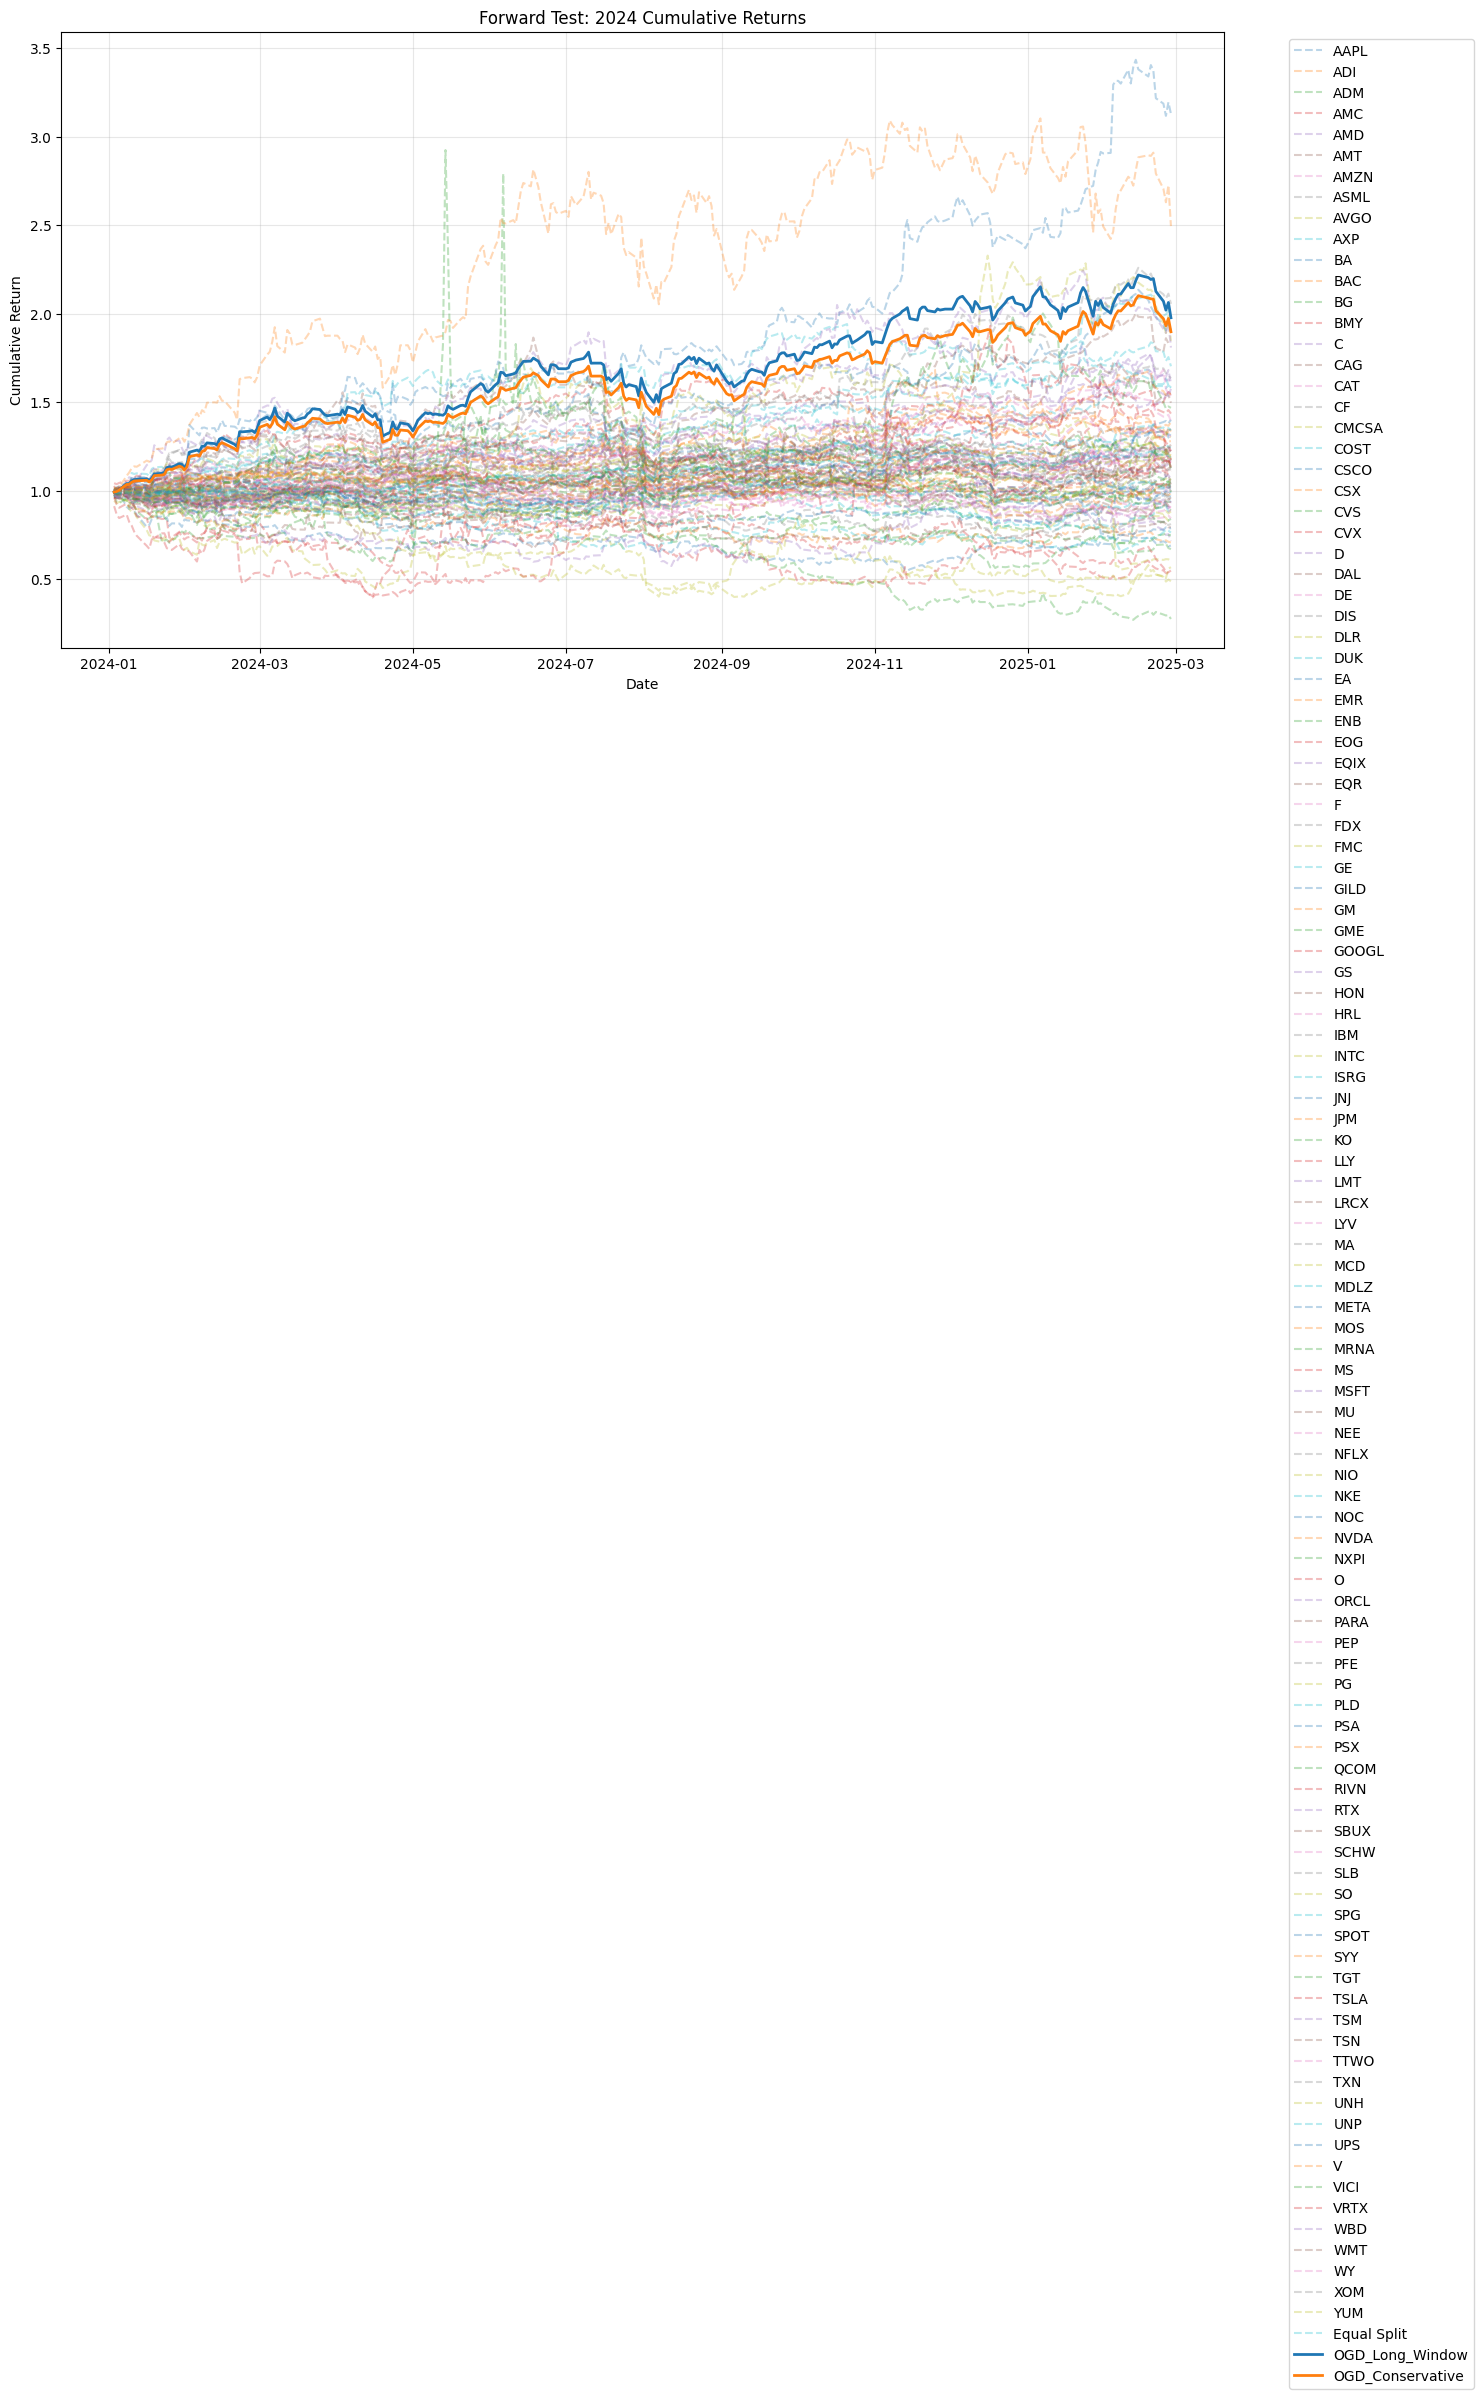

<Figure size 1500x800 with 0 Axes>

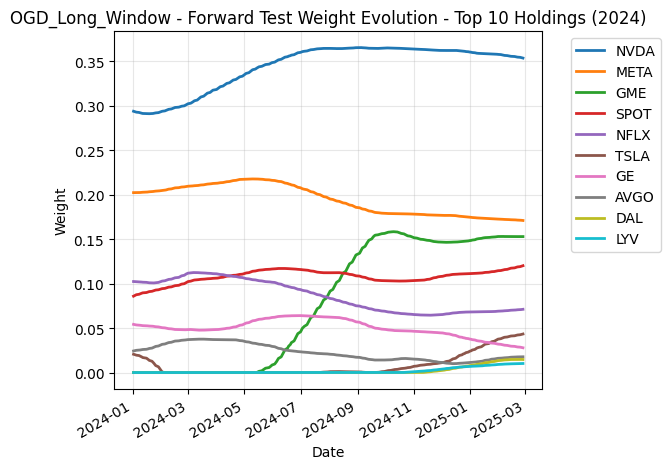

<Figure size 1500x800 with 0 Axes>

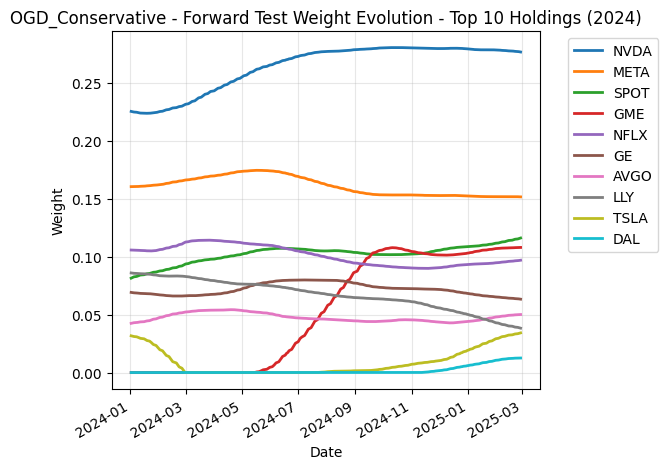


Final Cumulative Returns (2024):
SPOT: 3.13x
NVDA: 2.50x
NFLX: 2.06x
GE: 2.02x
OGD_Long_Window: 1.98x
META: 1.91x
OGD_Conservative: 1.90x
AVGO: 1.85x
WMT: 1.84x
TSM: 1.81x
ISRG: 1.70x
IBM: 1.64x
ORCL: 1.61x
GS: 1.60x
AXP: 1.58x
COST: 1.58x
RTX: 1.58x
C: 1.55x
JPM: 1.55x
LLY: 1.54x
LYV: 1.54x
DAL: 1.50x
GME: 1.47x
MS: 1.44x
GILD: 1.40x
AMZN: 1.39x
V: 1.39x
MA: 1.35x
SPG: 1.34x
GM: 1.33x
BAC: 1.33x
CSCO: 1.31x
TTWO: 1.31x
SO: 1.30x
AAPL: 1.29x
EMR: 1.28x
SBUX: 1.26x
DUK: 1.24x
DIS: 1.24x
EQR: 1.23x
GOOGL: 1.22x
D: 1.22x
KO: 1.22x
YUM: 1.22x
DE: 1.22x
ENB: 1.21x
DLR: 1.20x
PG: 1.19x
Equal Split: 1.19x
CAT: 1.18x
BMY: 1.18x
ADI: 1.18x
TXN: 1.17x
NEE: 1.16x
SCHW: 1.16x
VRTX: 1.15x
EQIX: 1.15x
TSN: 1.14x
TSLA: 1.13x
QCOM: 1.12x
XOM: 1.12x
MU: 1.12x
EOG: 1.11x
CVX: 1.11x
MCD: 1.07x
MSFT: 1.07x
JNJ: 1.06x
VICI: 1.05x
FDX: 1.05x
SYY: 1.04x
HON: 1.04x
UNP: 1.03x
LRCX: 1.03x
O: 1.03x
PSA: 1.02x
CF: 1.01x
LMT: 1.00x
NOC: 0.99x
NXPI: 0.99x
PSX: 0.99x
ASML: 0.98x
EA: 0.97x
AMT: 0.96x
PFE: 0.95x
WBD

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot results
plt.figure(figsize=(15, 8))

# Plot fundamental strategies with alpha 0.3
for strategy in fundamental_strategies.keys():
    if strategy in all_returns_df.columns:
        plt.plot(all_returns_df[strategy], alpha=0.3, linestyle='--', label=strategy)

# Plot OGD strategies with full opacity
for strategy in forward_results.keys():
    if strategy in all_returns_df.columns:
        plt.plot(all_returns_df[strategy], linewidth=2, label=strategy)

plt.title('Forward Test: 2024 Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot the weight evolution for the OGD strategies - TOP 10 STOCKS ONLY
for name, weights_df in forward_weights_history.items():
    plt.figure(figsize=(15, 8))

    # Get the top 10 stocks based on final portfolio weights
    last_weights = weights_df.iloc[-1]
    top10_stocks = last_weights.nlargest(10).index

    # Plot only the top 10 stocks
    weights_df[top10_stocks].plot(linewidth=2)

    plt.title(f'{name} - Forward Test Weight Evolution - Top 10 Holdings (2024)')
    plt.xlabel('Date')
    plt.ylabel('Weight')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Print final cumulative returns
print("\nFinal Cumulative Returns (2024):")
final_returns = {}

# Get the last value for each strategy
for strategy in all_returns_df.columns:
    final_returns[strategy] = all_returns_df[strategy].iloc[-1]

# Sort and print
final_returns = pd.Series(final_returns).sort_values(ascending=False)
for strategy in final_returns.index:
    print(f"{strategy}: {final_returns[strategy]:.2f}x")

# Print fitness scores
print("\nFitness Scores (2024):")
fitness_series = pd.Series(fitness_scores).sort_values(ascending=False)
for strategy in fitness_series.index:
    print(f"{strategy}: {fitness_series[strategy]:.4f}")

# Calculate risk metrics for all strategies
risk_metrics = {}

for strategy in all_returns_df.columns:
    returns = all_returns_df[strategy].pct_change().dropna()

    # Annualized return
    annualized_return = (all_returns_df[strategy].iloc[-1] ** (252 / len(returns)) - 1) * 100

    # Volatility (annualized)
    volatility = returns.std() * np.sqrt(252) * 100

    # Maximum drawdown
    cum_returns = all_returns_df[strategy]
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns / rolling_max - 1) * 100
    max_drawdown = drawdown.min()

    # Sharpe ratio (assuming 2% risk-free rate)
    excess_return = annualized_return - 2.0  # 2% risk-free
    sharpe = excess_return / volatility if volatility > 0 else 0

    risk_metrics[strategy] = {
        'Annual Return (%)': annualized_return,
        'Volatility (%)': volatility,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio': sharpe
    }

# Create a summary DataFrame
risk_summary = pd.DataFrame(risk_metrics).T
print("\nRisk Metrics (2024):")
print(risk_summary.sort_values('Annual Return (%)', ascending=False).round(2))

# Add information about portfolio concentration
print("\nPortfolio Concentration (Final Weights):")
for name, weights_df in forward_weights_history.items():
    last_weights = weights_df.iloc[-1]

    # Get non-zero positions (greater than 0.5%)
    active_positions = (last_weights > 0.005).sum()

    # Get top 10 concentration
    top10_concentration = last_weights.nlargest(10).sum() * 100

    # Get Herfindahl-Hirschman Index (HHI) - measure of concentration
    hhi = (last_weights ** 2).sum() * 10000  # Scaled by 10000 as is standard

    print(f"\n{name}:")
    print(f"  Active positions (>0.5%): {active_positions}")
    print(f"  Top 10 concentration: {top10_concentration:.2f}%")
    print(f"  HHI concentration index: {hhi:.2f} (higher = more concentrated)")
    print(f"  Top 5 holdings:")

    for i, (stock, weight) in enumerate(last_weights.nlargest(5).items(), 1):
        print(f"    {i}. {stock}: {weight*100:.2f}%")